<a href="https://colab.research.google.com/github/michalovsky/character_prediction/blob/master/character_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
from tensorflow.keras.constraints import max_norm
from keras.utils import np_utils
import numpy as np
import random
import os
import re
import string
import glob
import sys
import io
# GPU informations
print("GPU:", tf.test.gpu_device_name())

TensorFlow 2.x selected.
Tensorflow version: 2.0.0


Using TensorFlow backend.


GPU: /device:GPU:0


In [0]:
!git clone https://github.com/michalovsky/books_data.git

In [4]:
# Read all file paths from directory
directory1 = "books_data/kafka/"
directory2 = "books_data/shelley/"
directory3 = "books_data/defoe/"
directory4 = "books_data/nietzsche/"
directory5 = "books_data/dickens/"
directory6 = "books_data/joyce/"
directory7 = "books_data/sienkiewicz/"

directory = directory4
file_paths = glob.glob(directory +"*.txt")    
print("Found", len(file_paths), "text files in directory:", directory)

Found 1 text files in directory: books_data/nietzsche/


In [5]:
# Extract text from all text files
text = ""

for file_path in file_paths:
    with open(file_path, 'r') as file:
        file_content = file.read()
        #remove file beginning and ending from gutenberg books
        # file_content = file_content.replace("***START", "*** START") #temp
        # file_content = file_content.replace("***END", "*** END") #temp
        # file_content = file_content[file_content.find("*** START"):file_content.rfind("*** END")]
        # #remove file ending from wolnelektury books
        # file_content = file_content[:file_content.rfind("-----")]
        text+=file_content
print ('Length of text: {} characters'.format(len(text)))

Length of text: 600893 characters


In [6]:
# Preprocess data

punctuation_translator = str.maketrans('–—”„…«»‘’“°ſ†•✠', '               ', string.punctuation)
digits_translator = str.maketrans('', '', string.digits)
special_characters_translator = str.maketrans('ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœ', 'acelnoszzaoueeeeoaaaeceinouuuae', '')

# remove redundant characters and translate special characters
text = text.lower().translate(punctuation_translator).translate(digits_translator).translate(special_characters_translator)

# remove "rozdzial <number>" and "chapter <number>" strings 
text = re.sub(r"\nrozdzial\s(.*)\n", "", text)
text = re.sub(r"\nchapter\s(.*)\n", "", text)

#remove extra spaces and new lines
text = ' '.join(text.split())

print ('Length of text after preprocessing: {} characters'.format(len(text)))

Length of text after preprocessing: 576560 characters


In [7]:
# Creating a mapping from unique characters to indices
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
char2idx = dict((c, i) for i, c in enumerate(vocab))
idx2char = dict((i, c) for i, c in enumerate(vocab))
print ('{} unique characters:'.format(len(vocab)))
print(vocab)

27 unique characters:
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

sequence_length = 40
step = 3
sentences = []
labels = []
encoded = np.array([char2idx[ch] for ch in text]) 

for i in range(0, len(encoded) - sequence_length, step):
    sentences.append(encoded[i:i + sequence_length])
    labels.append(encoded[i + sequence_length])

data_size = len(sentences)
print("Data size:", data_size)

X = np.reshape(sentences, (data_size, sequence_length, 1))
X = np_utils.to_categorical(X)
y = np_utils.to_categorical(labels)

# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)
# Shuffle training set
X_train, y_train = shuffle(X_train, y_train, random_state=0)

Data size: 192174


In [47]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, vocab_size)))
model.add(BatchNormalization())
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model = Sequential()
# model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
# # recurrent_constraint=max_norm(3), bias_constraint=max_norm(3)))
# model.add(BatchNormalization())
# model.add(LSTM(256, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
# model.add(BatchNormalization())
# # model.add(LSTM(256, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
# # model.add(BatchNormalization())
# model.add(Dense(y.shape[1], activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128)               79872     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_10 (Dense)             (None, 27)                3483      
Total params: 83,867
Trainable params: 83,611
Non-trainable params: 256
_________________________________________________________________


In [0]:
# Setting callbacks

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(amount=100):
    start_index = random.randint(0, len(text) - sequence_length - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + sequence_length]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(amount):
            x_pred = np.zeros((1, sequence_length, vocab_size))
            for t, char in enumerate(sentence):
                x_pred[0, t, char2idx[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = idx2char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    generate_text()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=20)

# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
# checkpoint = ModelCheckpoint(filepath=checkpoint_prefix, monitor='loss', save_best_only=True, mode='min')

callbacks = [ es]

In [48]:
batch_size = 16 
epochs = 60
#0.6 beaten for seq_len=60, data=shelley, 3x256, dropouts 0.2, batch_size=64, epochs=40, 
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=callbacks)

Train on 153739 samples, validate on 38435 samples
Epoch 1/60
153739/153739 - 66s - loss: 2.1868 - accuracy: 0.3440 - val_loss: 2.0180 - val_accuracy: 0.3865
Epoch 2/60
153739/153739 - 64s - loss: 1.9492 - accuracy: 0.4094 - val_loss: 1.8102 - val_accuracy: 0.4416
Epoch 3/60
153739/153739 - 63s - loss: 1.7832 - accuracy: 0.4583 - val_loss: 1.6993 - val_accuracy: 0.4836
Epoch 4/60
153739/153739 - 63s - loss: 1.6762 - accuracy: 0.4906 - val_loss: 1.6213 - val_accuracy: 0.5032
Epoch 5/60
153739/153739 - 64s - loss: 1.6001 - accuracy: 0.5138 - val_loss: 1.5720 - val_accuracy: 0.5230
Epoch 6/60
153739/153739 - 64s - loss: 1.5445 - accuracy: 0.5306 - val_loss: 1.5455 - val_accuracy: 0.5328
Epoch 7/60
153739/153739 - 65s - loss: 1.5015 - accuracy: 0.5437 - val_loss: 1.5169 - val_accuracy: 0.5421
Epoch 8/60
153739/153739 - 65s - loss: 1.4663 - accuracy: 0.5535 - val_loss: 1.5004 - val_accuracy: 0.5480
Epoch 9/60
153739/153739 - 65s - loss: 1.4363 - accuracy: 0.5605 - val_loss: 1.4908 - val_acc

In [0]:
tf.train.latest_checkpoint(checkpoint_dir) #second param direct file: "ckpt_50"

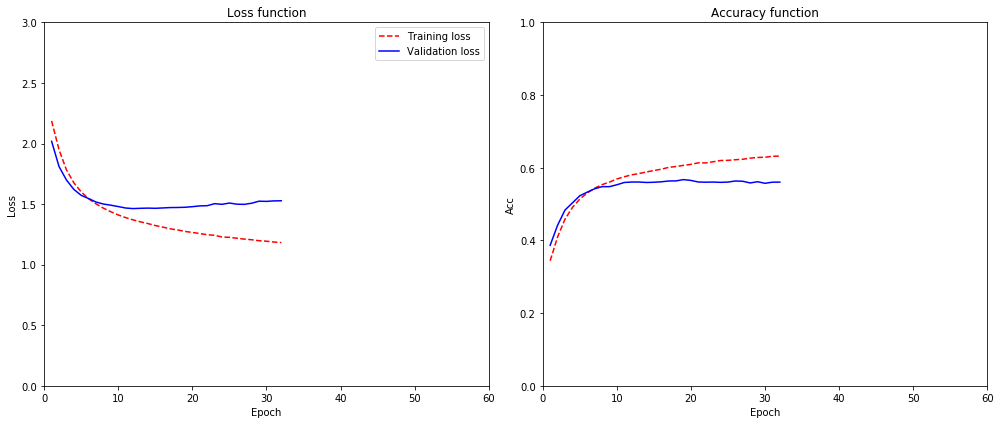

In [49]:
import matplotlib.pyplot as plt

# Make characteristics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)
# plt.savefig(save_directory+"/characteristics.png")  

plt.tight_layout()
plt.show()

In [50]:
generate_text()

----- diversity: 0.2
----- Generating with seed: "d frightfully with this very folly the d"
d frightfully with this very folly the destiny and conscience and as it is a present may be such a surplus of the fact that it is a propers 
----- diversity: 0.5
----- Generating with seed: "d frightfully with this very folly the d"
d frightfully with this very folly the destiny and as the pressite and have to be the form of the comparison in the spirit of great order of
----- diversity: 1.0
----- Generating with seed: "d frightfully with this very folly the d"
d frightfully with this very folly the deear among itsiltianic show this livet here is his idea vir more perseitence it destruction of a ts 
----- diversity: 1.2
----- Generating with seed: "d frightfully with this very folly the d"
d frightfully with this very folly the do happy primenrsthat orce bringer german with heet ensuors also ephintart soul arp what it myself lo
